In [9]:
# Imported libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import BaggingRegressor, BaggingClassifier, RandomForestClassifier
from scipy.stats import t
import statsmodels.api as sm
from scipy import stats
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

%matplotlib inline

import random

random.seed(24)

In [10]:
# loading in training data
ROOT_DIR = "."
file_path = os.path.join(ROOT_DIR, "training_dataset.csv")
train_data = pd.read_csv(file_path)
test_path = os.path.join(ROOT_DIR, "score.csv")
test_data_ = pd.read_csv(test_path)

In [11]:
# concatenate train and test data for preprocessing
data = train_data.append(test_data_)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84414 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                84414 non-null  int64  
 1   dt                        84414 non-null  object 
 2   weekday                   84414 non-null  object 
 3   year                      84414 non-null  int64  
 4   id_driver                 84414 non-null  int64  
 5   id_carrier_number         84414 non-null  object 
 6   dim_carrier_type          84414 non-null  object 
 7   dim_carrier_company_name  84365 non-null  object 
 8   home_base_city            84369 non-null  object 
 9   home_base_state           84369 non-null  object 
 10  carrier_trucks            84414 non-null  object 
 11  num_trucks                84344 non-null  float64
 12  interested_in_drayage     84414 non-null  object 
 13  port_qualified            84414 non-null  object 
 14  signup_s

In [12]:
# drop extraneous features, initialize label feature
data = data.drop(["Unnamed: 0"], axis=1)
data['label'] = 0
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84414 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dt                        84414 non-null  object 
 1   weekday                   84414 non-null  object 
 2   year                      84414 non-null  int64  
 3   id_driver                 84414 non-null  int64  
 4   id_carrier_number         84414 non-null  object 
 5   dim_carrier_type          84414 non-null  object 
 6   dim_carrier_company_name  84365 non-null  object 
 7   home_base_city            84369 non-null  object 
 8   home_base_state           84369 non-null  object 
 9   carrier_trucks            84414 non-null  object 
 10  num_trucks                84344 non-null  float64
 11  interested_in_drayage     84414 non-null  object 
 12  port_qualified            84414 non-null  object 
 13  signup_source             84414 non-null  object 
 14  ts_signu

In [13]:

#create dataframes that are sorted by most_recent_load_date and total_loads, respectively
data['most_recent_load_date'] = pd.to_datetime(data['most_recent_load_date'])
data_date_sorted = data.sort_values(by='most_recent_load_date', ascending=False)
data_load_sorted = data.sort_values(by='total_loads', ascending=False)
print(data_date_sorted['most_recent_load_date'].head())
print(data_load_sorted['total_loads'].head())


0       2021-02-17
33499   2021-02-17
33563   2021-02-17
33559   2021-02-17
33536   2021-02-17
Name: most_recent_load_date, dtype: datetime64[ns]
37367    4266.0
79110    4266.0
45024    4266.0
26816    4266.0
44889    4266.0
Name: total_loads, dtype: float64


In [14]:

#iterate through data, assigning labels of 1 to those that meet required cutoff based on most_recent_load_date and total_loads
date_cutoff = data_date_sorted["most_recent_load_date"].iloc[83414//4]
loads_cutoff = data_load_sorted["total_loads"].iloc[83414//4]
print(date_cutoff)
print(loads_cutoff)
for i in range(84414):
    if(data['most_recent_load_date'].iloc[i] >= date_cutoff and data['total_loads'].iloc[i] >= loads_cutoff):
        data['label'].iloc[i] = 1
    else:
        data['label'].iloc[i] = 0


2021-02-14 00:00:00
325.0


C:\Users\yoshi\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
#drop most_recent_load_date and total_loads
data = data.drop(["most_recent_load_date", "total_loads"], axis=1)

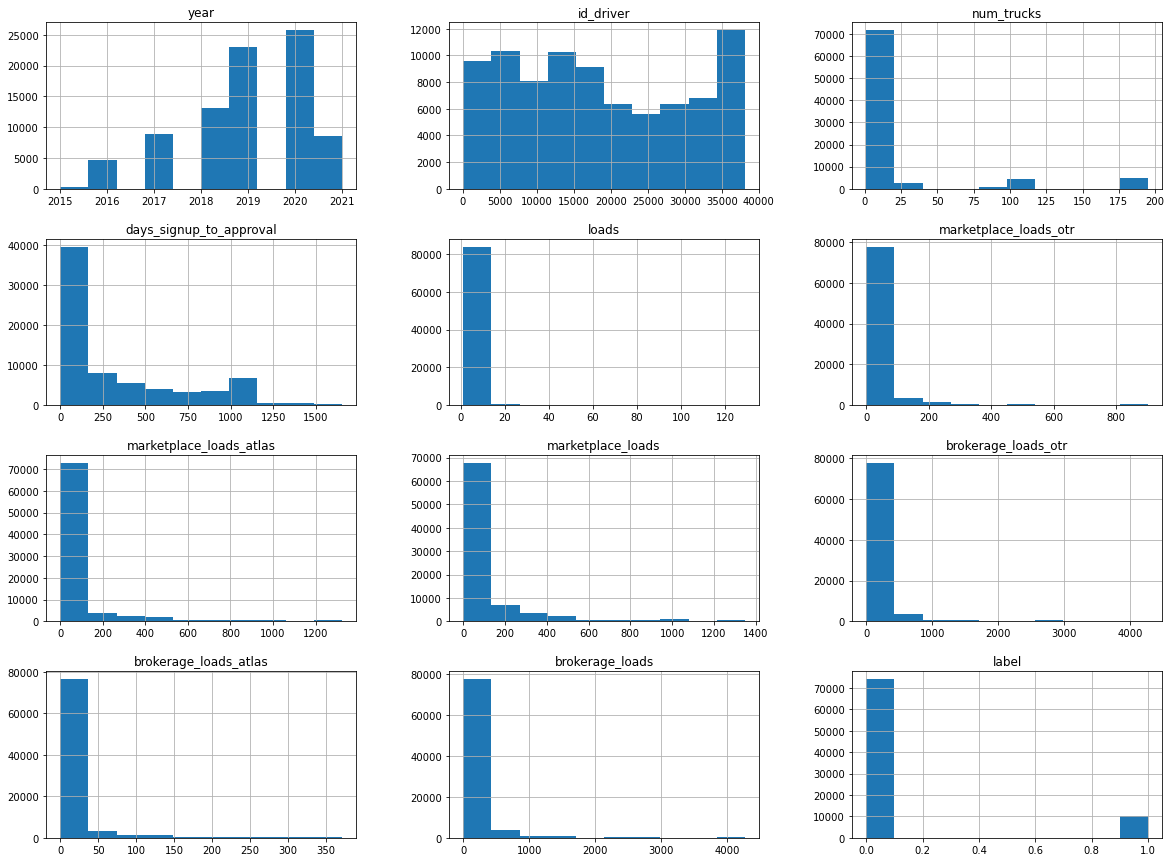

In [16]:
#plot features to see distributions
data.hist(figsize=(20,15), align='mid')
plt.show()

In [17]:
#drop features that won't be needed
data = data.drop(["dt", "weekday", "year", "id_driver", "signup_source", "first_load_date", "ts_signup", "ts_first_approved",
                 "dim_preferred_lanes", "load_day", "home_base_city", "id_carrier_number", "dim_carrier_company_name"], axis=1)

In [18]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84414 entries, 0 to 999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dim_carrier_type         84414 non-null  object 
 1   home_base_state          84369 non-null  object 
 2   carrier_trucks           84414 non-null  object 
 3   num_trucks               84344 non-null  float64
 4   interested_in_drayage    84414 non-null  object 
 5   port_qualified           84414 non-null  object 
 6   days_signup_to_approval  71978 non-null  float64
 7   driver_with_twic         84414 non-null  object 
 8   loads                    84414 non-null  int64  
 9   marketplace_loads_otr    84414 non-null  int64  
 10  marketplace_loads_atlas  84414 non-null  int64  
 11  marketplace_loads        84414 non-null  int64  
 12  brokerage_loads_otr      84414 non-null  int64  
 13  brokerage_loads_atlas    84414 non-null  int64  
 14  brokerage_loads         

<AxesSubplot:>

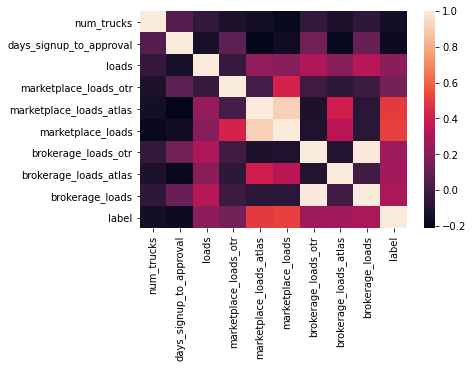

In [19]:
#plot feature correlation matrix
corr_matrix = data.corr()
sns.heatmap(corr_matrix)

In [20]:
#numerical representation of above plot
print(corr_matrix)

                         num_trucks  days_signup_to_approval     loads  \
num_trucks                 1.000000                 0.051573 -0.048151   
days_signup_to_approval    0.051573                 1.000000 -0.136858   
loads                     -0.048151                -0.136858  1.000000   
marketplace_loads_otr     -0.120255                 0.085015 -0.034094   
marketplace_loads_atlas   -0.150301                -0.213596  0.237985   
marketplace_loads         -0.185767                -0.159449  0.201740   
brokerage_loads_otr       -0.049881                 0.133193  0.312709   
brokerage_loads_atlas     -0.120857                -0.188274  0.207638   
brokerage_loads           -0.062506                 0.109355  0.335597   
label                     -0.147923                -0.173430  0.216259   

                         marketplace_loads_otr  marketplace_loads_atlas  \
num_trucks                           -0.120255                -0.150301   
days_signup_to_approval            

In [21]:
#print intro analysis to each feature
print(data.describe())

         num_trucks  days_signup_to_approval         loads  \
count  84344.000000             71978.000000  84414.000000   
mean      22.597185               298.803190      2.075473   
std       48.840386               390.414603      2.666080   
min        1.000000                 0.000000      1.000000   
25%        1.000000                 0.000000      1.000000   
50%        4.000000                61.000000      1.000000   
75%       14.000000               497.000000      2.000000   
max      195.000000              1653.000000    129.000000   

       marketplace_loads_otr  marketplace_loads_atlas  marketplace_loads  \
count           84414.000000             84414.000000       84414.000000   
mean               29.491447                71.547326         101.038773   
std                88.274149               194.479172         214.501677   
min                 0.000000                 0.000000           0.000000   
25%                 0.000000                 0.000000        

In [22]:
#One-hot encode dim_carrier_type earlier than pipeline to create cross term
ohe = OneHotEncoder()
feat_to_tf = ['dim_carrier_type']
cp_encoded = ohe.fit_transform(data[feat_to_tf]).toarray()
new_features = ohe.get_feature_names(feat_to_tf)
data[new_features] = cp_encoded
data = data.drop(feat_to_tf, axis=1)

In [23]:
#drop rows with null value in home_base_state and/or num_trucks
data = data.dropna(subset=["home_base_state", "num_trucks"])

In [24]:
#impute median value into missing attributes
imputer = SimpleImputer(strategy="median") # use median imputation for missing values
data["num_trucks_fleet"] = data["num_trucks"] * data["dim_carrier_type_Fleet"]
data["num_trucks_operator"] = data["num_trucks"] * data["dim_carrier_type_Owner Operator"]
median = data["days_signup_to_approval"].median() 
data["days_signup_to_approval"].fillna(median, inplace=True)

In [25]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84300 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   home_base_state                  84300 non-null  object 
 1   carrier_trucks                   84300 non-null  object 
 2   num_trucks                       84300 non-null  float64
 3   interested_in_drayage            84300 non-null  object 
 4   port_qualified                   84300 non-null  object 
 5   days_signup_to_approval          84300 non-null  float64
 6   driver_with_twic                 84300 non-null  object 
 7   loads                            84300 non-null  int64  
 8   marketplace_loads_otr            84300 non-null  int64  
 9   marketplace_loads_atlas          84300 non-null  int64  
 10  marketplace_loads                84300 non-null  int64  
 11  brokerage_loads_otr              84300 non-null  int64  
 12  brokerage_loads_atla

In [26]:
#data pipeline
labels = data["label"]
data_unlabeled = data.drop("label", axis=1)

data_num = data_unlabeled.drop(["dim_carrier_type_Fleet", "dim_carrier_type_Owner Operator", "home_base_state","carrier_trucks",
                                "interested_in_drayage","port_qualified", "driver_with_twic"], axis=1)
data_cat = data_unlabeled[["home_base_state","carrier_trucks", "interested_in_drayage","port_qualified", "driver_with_twic"]]
        
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

numerical_features = list(data_num)
categorical_features = list(data_cat)

full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), categorical_features),
        ("num", num_pipeline, numerical_features),
    ])

data_prepared = full_pipeline.fit_transform(data_unlabeled).toarray()

In [27]:
#separate data into training and test 
test_data = data_prepared[83300:]
test_labels = labels[83300:]
data_prepared = data_prepared[:83300]
labels = labels[:83300]

In [28]:
#split training data into train and validation sets
data_target = labels
X_train, X_test, y_train, y_test = train_test_split(data_prepared, data_target, test_size=0.2, random_state=24) 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(type(data_target))

(66640, 71)
(66640,)
(16660, 71)
(16660,)
<class 'pandas.core.series.Series'>


In [34]:
#Logistic Regression model, printing R2 score and F1 score
LR = LogisticRegression(max_iter=500)
reg = LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)
print(LR.score(X_test, y_test))
print(f1_score(y_test, y_pred))

0.9087635054021609
0.5486935866983372


In [35]:
#Bootstrapping Classifier, outputting t-value and p-value for each
BR = BaggingClassifier(LR, n_estimators=100, bootstrap=True,max_samples=66000)
BR.fit(X_train, y_train)
intercept=[]
beta1=[]
for m in BR.estimators_:
    intercept.append(m.intercept_)
    beta1.append(m.coef_[0])
np.std(intercept),np.std(beta1),np.mean(intercept),np.mean(beta1)

t_value = np.mean(beta1)/np.std(beta1)
print("t-value = ", t_value)
print("p-value = ", t.sf(t_value, 65998))


t-value =  -0.09092825785564887
p-value =  0.5362250636894733


In [29]:
#Dimensionality Reduction on features, used TruncatedSVD because can't use PCA on a sparse matrix
tsvd = TruncatedSVD(n_components=5)
tsvd.fit(data_prepared)
print(tsvd.explained_variance_ratio_)
print(tsvd.singular_values_)
data_prepared_transformed = tsvd.transform(data_prepared)
tsvd = TruncatedSVD(n_components=5)
tsvd.fit(test_data)
print(tsvd.explained_variance_ratio_)
print(tsvd.singular_values_)
test_data_transformed = tsvd.transform(test_data)

[0.18716199 0.09945653 0.15462493 0.14155783 0.10179264]
[519.42306611 497.25718329 439.18373299 407.57319039 333.92429467]
[0.20376805 0.0915811  0.14809434 0.12561702 0.11380326]
[57.47100477 54.13116088 47.21153124 40.06111789 37.9827252 ]


In [24]:
#Ensemble method (RandomForestClassifier), outputting R2 score and F1 score
rfr = RandomForestClassifier(n_estimators=100, random_state=24)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print(rfr.score(X_test, y_test))
print(f1_score(y_test, y_pred))

1.0
1.0


In [40]:
#Neural Network implementation (MLPClassifier), using features from dimensionality reduction, outputting F1 score
X_train_tf, X_test_tf, y_train, y_test = train_test_split(data_prepared_transformed, data_target, test_size=0.2, random_state=24) 
mlpc = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver='adam', alpha=1e-4, learning_rate='constant',
                    learning_rate_init=1e-3, random_state=24, verbose=True)
mlpc.fit(X_train_tf, y_train)
y_pred = mlpc.predict(X_test_tf)
print(mlpc.score(X_test_tf, y_test))
print(f1_score(y_test, y_pred))

Iteration 1, loss = 0.26607983
Iteration 2, loss = 0.17483718
Iteration 3, loss = 0.15821045
Iteration 4, loss = 0.14842676
Iteration 5, loss = 0.14128851
Iteration 6, loss = 0.13534587
Iteration 7, loss = 0.13040251
Iteration 8, loss = 0.12525184
Iteration 9, loss = 0.12079332
Iteration 10, loss = 0.11635620
Iteration 11, loss = 0.11191708
Iteration 12, loss = 0.10804801
Iteration 13, loss = 0.10434663
Iteration 14, loss = 0.10118650
Iteration 15, loss = 0.09847613
Iteration 16, loss = 0.09585397
Iteration 17, loss = 0.09371488
Iteration 18, loss = 0.09180125
Iteration 19, loss = 0.09025961
Iteration 20, loss = 0.08858048
Iteration 21, loss = 0.08702317
Iteration 22, loss = 0.08605363
Iteration 23, loss = 0.08424941
Iteration 24, loss = 0.08312328
Iteration 25, loss = 0.08212001
Iteration 26, loss = 0.08086487
Iteration 27, loss = 0.07966049
Iteration 28, loss = 0.07868468
Iteration 29, loss = 0.07845348
Iteration 30, loss = 0.07712059
Iteration 31, loss = 0.07614415
Iteration 32, los

C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
#K-fold Cross Validation on Ensemble method, outputting average R2 score and average F1 score
n_splits = 10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=24)
max_depth_list = [16]
#n_estimators_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_estimators_list = [50]
for i in range(len(max_depth_list)):
    for j in range(len(n_estimators_list)):
        acc = 0
        f1score = 0
        print("Max Depth: ", max_depth_list[i])
        print("# of Estimators: ", n_estimators_list[j])
        for train_index, test_index in sss.split(data_prepared, data_target):
            X_train, X_test = data_prepared[train_index], data_prepared[test_index]
            y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]
            rfr = RandomForestClassifier(n_estimators=n_estimators_list[j], max_depth=max_depth_list[i], random_state=24)
            rfr.fit(X_train, y_train)
            y_pred = rfr.predict(X_test)
            acc = acc + rfr.score(X_test, y_test)
            f1 = f1_score(y_test, y_pred)
            f1score = f1score + f1
        print("Avg R2 Score: ", acc/n_splits)
        print("Avg F1 Score: ", f1score/n_splits)

Max Depth:  16
# of Estimators:  50
Avg R2 Score:  1.0
Avg F1 Score:  1.0


In [37]:
# K-fold Cross Validation on Neural Network, outputting average R2 score and average F1 score
#architecture = (100,), learning rate = 1e-3, layer activations = relu, optimizer = adam, alpha = 1e-4, learning_rate=constant,
# tuning for optimizer
acc = 0
f1score = 0
n_splits = 10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=24)
solver_list = ['sgd', 'adam']
for i in range(len(solver_list)):
    acc = 0
    f1score = 0
    mlpc = MLPClassifier(hidden_layer_sizes=100, activation='relu', solver=solver_list[i], alpha=1e-4, 
                         learning_rate='constant', learning_rate_init=1e-3, random_state=24, verbose=False)
    for train_index, test_index in sss.split(data_prepared_transformed, data_target):
        X_train, X_test = data_prepared_transformed[train_index], data_prepared_transformed[test_index]
        y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]
        mlpc.fit(X_train, y_train)
        y_pred = mlpc.predict(X_test)
        acc = acc + mlpc.score(X_test, y_test)
        f1 = f1_score(y_test, y_pred)
        f1score = f1score + f1
    print("Avg R2 Score (", solver_list[i], "): ", acc/n_splits)
    print("Avg F1 Score: (", solver_list[i], "):", f1score/n_splits)

C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Avg R2 Score ( sgd ):  0.9517226890756302
Avg F1 Score: ( sgd ): 0.8003946493096155


C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Avg R2 Score ( adam ):  0.9870048019207681
Avg F1 Score: ( adam ): 0.9483593613470471


C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
#tuning NN, trying different activation functions
#architecture = (100,), learning rate = 1e-3, layer activations = relu, optimizer = adam, alpha = 1e-4, learning_rate=constant,
# tuning for activation
acc = 0
f1score = 0
n_splits = 10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=24)
activation_list = ['relu', 'logistic', 'tanh']
for i in range(len(activation_list)):
    acc = 0
    f1score = 0
    mlpc = MLPClassifier(hidden_layer_sizes=100, activation=activation_list[i], solver='adam', alpha=1e-4, 
                         learning_rate='constant', learning_rate_init=1e-3, random_state=24, verbose=False)
    for train_index, test_index in sss.split(data_prepared_transformed, data_target):
        X_train, X_test = data_prepared_transformed[train_index], data_prepared_transformed[test_index]
        y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]
        mlpc.fit(X_train, y_train)
        y_pred = mlpc.predict(X_test)
        acc = acc + mlpc.score(X_test, y_test)
        f1 = f1_score(y_test, y_pred)
        f1score = f1score + f1
    print("Avg Accuracy (", activation_list[i], "): ", acc/n_splits)
    print("Avg F1 Score: (", activation_list[i], "):", f1score/n_splits)

In [38]:
#Tuning NN, trying different optimizers
#architecture = (100,), learning rate = 1e-3, layer activations = tanh, optimizer = adam, alpha = 1e-4, learning_rate=constant,
# tuning for optimizer
#finalized model!
acc = 0
f1score = 0
n_splits = 10
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=24)
solver_list = ['sgd', 'adam']
for i in range(len(solver_list)):
    acc = 0
    f1score = 0
    mlpc = MLPClassifier(hidden_layer_sizes=100, activation='tanh', solver=solver_list[i], alpha=1e-4, 
                         learning_rate='constant', learning_rate_init=1e-3, random_state=24, verbose=False)
    for train_index, test_index in sss.split(data_prepared_transformed, data_target):
        X_train, X_test = data_prepared_transformed[train_index], data_prepared_transformed[test_index]
        y_train, y_test = data_target.iloc[train_index], data_target.iloc[test_index]
        mlpc.fit(X_train, y_train)
        y_pred = mlpc.predict(X_test)
        acc = acc + mlpc.score(X_test, y_test)
        f1 = f1_score(y_test, y_pred)
        f1score = f1score + f1
    print("Avg Accuracy (", solver_list[i], "): ", acc/n_splits)
    print("Avg F1 Score: (", solver_list[i], "):", f1score/n_splits)

C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Avg Accuracy ( sgd ):  0.9456842737094838
Avg F1 Score: ( sgd ): 0.7730742715927982


C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Avg Accuracy ( adam ):  0.9927250900360143
Avg F1 Score: ( adam ): 0.9712265628433716


C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
#Producing predictions on test data
mlpc = MLPClassifier(hidden_layer_sizes=100, activation='tanh', solver='adam', alpha=1e-4, 
                         learning_rate='constant', learning_rate_init=1e-3, random_state=24, verbose=False)
mlpc.fit(data_prepared_transformed, data_target)
y_pred = mlpc.predict(test_data_transformed)
print(y_pred)

[0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0
 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 0 0 

C:\Users\yoshi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
# trying random forest classifier for prediction (best model)
rfr = RandomForestClassifier(n_estimators=100, max_depth=16, random_state=24, criterion='entropy')
rfr.fit(data_prepared, data_target)
y_pred = rfr.predict(test_data)

In [45]:
ids = np.arange(83414,84414)
df = pd.DataFrame(y_pred)
ids = pd.DataFrame(ids)
df = df.rename(columns={0:"Predicted"})
ids = ids.rename(columns={0:"Id"})
result = pd.concat([ids, df], axis=1, join='inner') 
print(result)

        Id  Predicted
0    83414          0
1    83415          0
2    83416          0
3    83417          0
4    83418          0
..     ...        ...
995  84409          0
996  84410          0
997  84411          0
998  84412          0
999  84413          0

[1000 rows x 2 columns]


In [46]:
result.to_csv('predictions.csv', index=False)